In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np


In [2]:
class PositioningNetwork(nn.Module):
    def __init__(self, input_size=30, hidden_sizes=[1000, 1000, 500, 100, 10], output_size=2):
        super(PositioningNetwork, self).__init__()
        layers = []
        sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1]))
            if i < len(sizes) - 2:
                layers.append(nn.ReLU())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [3]:
# Define a basic neural network for regression
class SimplePositioningNetwork(nn.Module):
    def __init__(self, input_size=30, hidden_layers=[1000, 1000, 500, 100, 10], output_size=2):
        """
        Initializes a fully connected neural network.

        Parameters:
        - input_size: Number of input features.
        - hidden_layers: List containing the sizes of each hidden layer.
        - output_size: Number of output features.
        """
        super(SimplePositioningNetwork, self).__init__()
        layers = []
        sizes = [input_size] + hidden_layers + [output_size]

        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1]))
            if i < len(sizes) - 2:
                layers.append(nn.ReLU())  # Add activation only between hidden layers

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [4]:
# Bilinear interpolation-based loss function
def interpolated_loss(output, region_map, region_map_topo):
    # Normalize coordinates to region map size
    H, W = region_map_topo.shape
    output[:, 0] = torch.clamp(output[:, 0], 0, region_map.shape[1] - 1)  # Clip x values
    output[:, 1] = torch.clamp(output[:, 1], 0, region_map.shape[0] - 1)  # Clip y values

    x = output[:, 0].detach().cpu().numpy()
    y = output[:, 1].detach().cpu().numpy()

    x1 = np.floor(x).astype(int)
    x2 = x1 + 1
    y1 = np.floor(y).astype(int)
    y2 = y1 + 1

    # Bilinear interpolation
    Q11 = region_map_topo[y1, x1]
    Q12 = region_map_topo[y2, x1]
    Q21 = region_map_topo[y1, x2]
    Q22 = region_map_topo[y2, x2]

    # Weights for interpolation
    wx = x - x1
    wy = y - y1

    # Calculate interpolated value
    interpolated_value = (1 - wx) * (1 - wy) * Q11 + (1 - wx) * wy * Q12 + wx * (1 - wy) * Q21 + wx * wy * Q22

    # Define constraining loss (zero for valid positions, non-zero for invalid)
    return interpolated_value.mean()

In [5]:
def train(model, data_loader, region_map, region_map_topo, epochs=100, batch_size=128, learning_rate=0.001, alpha=1.0, step_size=10, threshold=1.0):
    device = "cuda" if torch.cuda.is_available() else "cpu"  # Define device here
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)  # Learning rate scheduler


    for epoch in range(epochs):
        for features, target in data_loader:
            optimizer.zero_grad()
            features = features.to(device)
            target = target.to(device)

            # Get predictions
            predicted_positions = model(features)

            # Calculate positioning loss
            pos_loss = torch.mean(torch.sum((predicted_positions - target)**2, dim=1))

            # Calculate constraint loss (avoid invalid areas)
            # Convert predicted_positions to integers for indexing
            predicted_positions_int = predicted_positions.long()


            # Calculate constraint mask
            constraint_mask = region_map_topo[target[:, 1].long(), target[:, 0].long()] > threshold

            # Convert constraint_mask to float for loss calculation
            constraint_loss = torch.mean(torch.tensor(constraint_mask, dtype=torch.float32))

            # Total loss
            loss = alpha * pos_loss + (1 - alpha) * constraint_loss

            loss.backward()
            optimizer.step()

        scheduler.step()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

In [10]:
def test_model(model, test_loader, region_map, topographic_map, device="cpu"):
    """
    Test the model on a test dataset and calculate positioning error and invalid output ratio.

    Parameters:
    - model: The trained PyTorch model.
    - test_loader: DataLoader for the test dataset.
    - region_map: Binary matrix where 0 indicates valid regions and 1 indicates invalid regions.
    - topographic_map: Matrix with distances from each invalid cell to the nearest valid cell.
    - device: Device to perform computations ("cpu" or "cuda").

    Returns:
    - avg_positioning_error: Average positioning error over the test set.
    - invalid_output_ratio: Ratio of outputs falling in invalid regions.
    - avg_penalty: Average penalty from the topographic map for invalid predictions.
    """
    model.eval()  # Set model to evaluation mode
    total_positioning_error = 0.0
    total_invalid_outputs = 0
    total_penalty = 0.0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation for testing
        for features, target in test_loader:
            features, target = features.to(device), target.to(device)

            # Predict the position
            predicted_position = model(features)

            # Calculate positioning error (L2 distance between prediction and target)
            positioning_error = torch.sqrt(((predicted_position - target) ** 2).sum(dim=1))
            total_positioning_error += positioning_error.sum().item()

            # Check if the predicted positions are in valid regions
            h, w = region_map.shape
            x_pred, y_pred = predicted_position[:, 0].long(), predicted_position[:, 1].long()

            # Ensure predictions are within bounds before indexing
            x_pred = torch.clamp(x_pred, 0, w - 1)
            y_pred = torch.clamp(y_pred, 0, h - 1)

            # Count invalid outputs and calculate penalties from the topographic map
            invalid_mask = (region_map[y_pred, x_pred] == 1)
            total_invalid_outputs += invalid_mask.sum().item()
            penalty = topographic_map[y_pred, x_pred] * invalid_mask.float()  # Apply penalty only for invalid outputs
            total_penalty += penalty.sum().item()
            total_samples += target.size(0)

    # Calculate average positioning error, invalid output ratio, and average penalty
    avg_positioning_error = total_positioning_error / total_samples
    invalid_output_ratio = total_invalid_outputs / total_samples
    avg_penalty = total_penalty / total_invalid_outputs if total_invalid_outputs > 0 else 0

    print(f"Average Positioning Error: {avg_positioning_error:.4f}")
    print(f"Invalid Output Ratio: {invalid_output_ratio * 100:.2f}%")
    print(f"Average Topographic Penalty for Invalid Outputs: {avg_penalty:.4f}")

    return avg_positioning_error, invalid_output_ratio, avg_penalty


In [15]:
def train_basic_model(model, train_loader, loss_fn, optimizer, device="cpu", epochs=100):
    """
    Train the model with basic regression (no knowledge of valid/invalid regions).

    Parameters:
    - model: The neural network model to be trained.
    - train_loader: DataLoader for the training data.
    - loss_fn: Regression loss function (e.g., MSE).
    - optimizer: Optimizer (e.g., Adam, SGD).
    - device: Device to perform computations ("cpu" or "cuda").
    - epochs: Number of training epochs.
    """
    model.to(device)
    model.train()  # Set model to training mode

    for epoch in range(epochs):
        epoch_loss = 0.0
        for features, target in train_loader:
            features, target = features.to(device), target.to(device)

            optimizer.zero_grad()  # Clear gradients
            output = model(features)
            loss = loss_fn(output, target)  # Compute the regression loss
            loss.backward()  # Backpropagate the error
            optimizer.step()  # Update the model parameters

            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}")

# Define the testing function
def test_basic_model(model, test_loader, device="cpu"):
    """
    Test the model on a test dataset without considering valid/invalid regions.

    Parameters:
    - model: The trained PyTorch model.
    - test_loader: DataLoader for the test dataset.
    - device: Device to perform computations ("cpu" or "cuda").

    Returns:
    - avg_positioning_error: Average positioning error over the test set.
    """
    model.eval()  # Set model to evaluation mode
    total_positioning_error = 0.0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation for testing
        for features, target in test_loader:
            features, target = features.to(device), target.to(device)

            # Predict the position
            predicted_position = model(features)

            # Calculate positioning error (L2 distance between prediction and target)
            positioning_error = torch.sqrt(((predicted_position - target) ** 2).sum(dim=1))
            total_positioning_error += positioning_error.sum().item()
            total_samples += target.size(0)

    # Calculate average positioning error
    avg_positioning_error = total_positioning_error / total_samples
    print(f"Average Positioning Error: {avg_positioning_error:.4f}")

    return avg_positioning_error

In [7]:
from torch.utils.data import Dataset, DataLoader
import cv2

def generate_region_map(size=(100, 100), circle_center=(50, 50), circle_radius=20):
    """
    Generates a binary region map with a circular invalid area.

    Parameters:
    - size: tuple, dimensions of the region map (height, width).
    - circle_center: tuple, coordinates of the center of the invalid circle (y, x).
    - circle_radius: int, radius of the invalid circular area.

    Returns:
    - region_map: binary matrix with 0 for valid areas and 1 for invalid areas.
    """
    region_map = torch.zeros(size, dtype=torch.float32)
    y, x = torch.meshgrid(torch.arange(size[0]), torch.arange(size[1]), indexing='ij')
    mask = ((x - circle_center[1])**2 + (y - circle_center[0])**2) <= circle_radius**2
    region_map[mask] = 1  # Mark invalid regions
    return region_map

def generate_topographic_map(region_map):
    """
    Generates a topographic map from a binary region map.

    Parameters:
    - region_map: Binary matrix where 0 indicates valid regions and 1 indicates invalid regions.

    Returns:
    - topographic_map: Matrix with distances from each invalid cell to the nearest valid cell.
    """
    # Convert the region map to an inverted map (1 for valid, 0 for invalid)
    inverted_map = (1 - region_map).astype(np.uint8)

    # Use OpenCV's distance transform to get distances in the inverted map
    topographic_map = cv2.distanceTransform(inverted_map, distanceType=cv2.DIST_L2, maskSize=5)
    return torch.tensor(topographic_map, dtype=torch.float32)

def generate_known_positions(num_positions, region_map):
    """
    Generate a list of known positions within valid areas of the region map.

    Parameters:
    - num_positions: Number of known positions to generate.
    - region_map: Binary matrix indicating valid and invalid regions.

    Returns:
    - known_positions: Tensor of valid (x, y) positions.
    """
    valid_positions = torch.nonzero(region_map == 0, as_tuple=False)  # Get all valid positions
    indices = torch.randperm(valid_positions.size(0))[:num_positions]  # Randomly select positions
    return valid_positions[indices]

def calculate_distances(target, known_positions, noise_mean=0, noise_std=5):
    """
    Calculate distances from the target position to each known position with added Gaussian noise.

    Parameters:
    - target: Tensor containing the target (x, y) position.
    - known_positions: Tensor containing (x, y) coordinates of known positions.
    - noise_mean: Mean of Gaussian noise.
    - noise_std: Standard deviation of Gaussian noise.

    Returns:
    - distances: Tensor of noisy distances.
    """
    distances = torch.sqrt(((known_positions - target) ** 2).sum(dim=1))
    noise = torch.normal(mean=noise_mean, std=noise_std, size=distances.shape)
    return distances + noise




In [8]:
class PositionDataset(Dataset):
    def __init__(self, region_map, known_positions, num_samples=100000, noise_mean=0, noise_std=5, max_known_positions=10):
        """
        Initialize the dataset with the given parameters.

        Parameters:
        - region_map: Binary matrix with 0 for valid areas and 1 for invalid areas.
        - known_positions: Tensor containing valid (x, y) coordinates of known positions.
        - num_samples: Total number of samples in the dataset.
        - noise_mean: Mean of Gaussian noise for distances.
        - noise_std: Standard deviation of Gaussian noise.
        - max_known_positions: Maximum number of known positions to include in each sample.
        """
        self.region_map = region_map
        self.known_positions = known_positions
        self.num_samples = num_samples
        self.noise_mean = noise_mean
        self.noise_std = noise_std
        self.max_known_positions = max_known_positions

        # Get all valid positions from region_map
        self.valid_positions = torch.nonzero(region_map == 0, as_tuple=False)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Select a random valid target position
        target_index = torch.randint(0, self.valid_positions.size(0), (1,))
        target = self.valid_positions[target_index].squeeze()  # (x, y) coordinates

        # Calculate noisy distances to known positions
        distances = calculate_distances(target, self.known_positions, self.noise_mean, self.noise_std)

        # Randomly select a subset of known positions and distances
        selected_indices = torch.randperm(self.known_positions.size(0))[:self.max_known_positions]
        selected_distances = distances[selected_indices]
        selected_positions = self.known_positions[selected_indices].flatten()  # Flattened (x, y) pairs

        # Concatenate distances and selected positions to form features
        features = torch.cat((selected_distances, selected_positions))
        return features, target.float()

In [9]:
# Parameters
region_map_size = (100, 100)
circle_center = (50, 50)
circle_radius = 20

# Generate region map and known positions
region_map = generate_region_map(size=region_map_size, circle_center=circle_center, circle_radius=circle_radius)
topographic_map = generate_topographic_map(region_map.numpy())
known_positions = generate_known_positions(num_positions=10, region_map=region_map)

# Create dataset and data loaders
train_dataset = PositionDataset(region_map, known_positions, num_samples=100000)
test_dataset = PositionDataset(region_map, known_positions, num_samples=10000)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)


Features shape: torch.Size([1024, 30])
Target shape: torch.Size([1024, 2])


In [12]:

import matplotlib.pyplot as plt

def plot_predictions(model, test_loader, region_map, device="cpu"):
    """
    Plots the correct vs predicted outputs for the test region.

    Parameters:
    - model: The trained PyTorch model.
    - test_loader: DataLoader for the test dataset.
    - region_map: Binary matrix indicating valid and invalid regions.
    - device: Device to perform computations ("cpu" or "cuda").
    """
    model.eval()
    predicted_positions = []
    target_positions = []

    with torch.no_grad():
        for features, target in test_loader:
            features, target = features.to(device), target.to(device)
            predicted_position = model(features)
            predicted_positions.extend(predicted_position.cpu().numpy())
            target_positions.extend(target.cpu().numpy())

    predicted_positions = np.array(predicted_positions)
    target_positions = np.array(target_positions)

    plt.figure(figsize=(8, 8))
    plt.scatter(predicted_positions[:, 0], predicted_positions[:, 1], c='red', label='Predicted Positions')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Predicted Output with Valid Regions Grey and Invalid Regions White')
    plt.legend()

    # Overlay the invalid region (if available)
    if region_map is not None:
        invalid_region = (region_map.cpu().numpy() == 1)
        plt.imshow(invalid_region, cmap='gray', alpha=0.3, extent=[0, region_map.shape[1], region_map.shape[0], 0])

    plt.show()




In [11]:
model = PositioningNetwork()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
region_map = region_map.to(device)
topographic_map = topographic_map.to(device)
train(model, train_loader, region_map, topographic_map)

<ipython-input-5-1656843326d0>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  constraint_loss = torch.mean(torch.tensor(constraint_mask, dtype=torch.float32))


Epoch 1/100, Loss: 211.7284698486328
Epoch 2/100, Loss: 58.72258758544922
Epoch 3/100, Loss: 40.62104797363281
Epoch 4/100, Loss: 35.862491607666016
Epoch 5/100, Loss: 27.829545974731445
Epoch 6/100, Loss: 29.33012580871582
Epoch 7/100, Loss: 31.713071823120117
Epoch 8/100, Loss: 34.072967529296875
Epoch 9/100, Loss: 31.444046020507812
Epoch 10/100, Loss: 28.455453872680664
Epoch 11/100, Loss: 21.00289535522461
Epoch 12/100, Loss: 21.175844192504883
Epoch 13/100, Loss: 23.961437225341797
Epoch 14/100, Loss: 21.068254470825195
Epoch 15/100, Loss: 18.871179580688477
Epoch 16/100, Loss: 22.197322845458984
Epoch 17/100, Loss: 21.00652313232422
Epoch 18/100, Loss: 19.12481689453125
Epoch 19/100, Loss: 21.13610076904297
Epoch 20/100, Loss: 21.995283126831055
Epoch 21/100, Loss: 19.48221206665039
Epoch 22/100, Loss: 19.434612274169922
Epoch 23/100, Loss: 19.7847957611084
Epoch 24/100, Loss: 20.291025161743164
Epoch 25/100, Loss: 18.657546997070312
Epoch 26/100, Loss: 18.88886070251465
Epoch 2

Average Positioning Error: 3.5885
Invalid Output Ratio: 0.64%
Average Topographic Penalty for Invalid Outputs: 0.0000


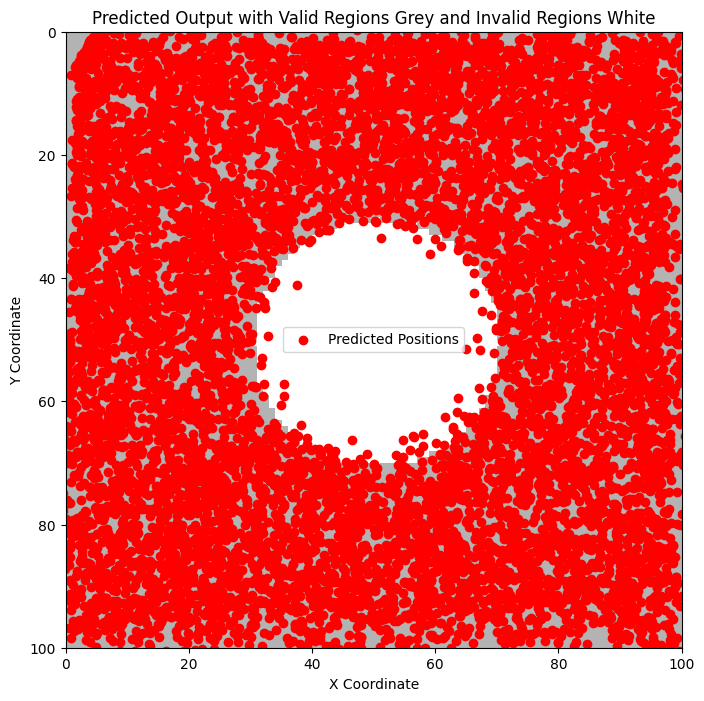

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
test_model(model, test_loader, region_map.to(device), topographic_map.to(device), device=device)# After training the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
plot_predictions(model, test_loader, region_map, device=device)

Epoch 1/100, Loss: 808.1745
Epoch 2/100, Loss: 219.6820
Epoch 3/100, Loss: 37.0240
Epoch 4/100, Loss: 20.5809
Epoch 5/100, Loss: 16.9193
Epoch 6/100, Loss: 15.7463
Epoch 7/100, Loss: 15.7552
Epoch 8/100, Loss: 13.5954
Epoch 9/100, Loss: 13.5924
Epoch 10/100, Loss: 13.1424
Epoch 11/100, Loss: 12.4271
Epoch 12/100, Loss: 12.0268
Epoch 13/100, Loss: 11.5999
Epoch 14/100, Loss: 12.4025
Epoch 15/100, Loss: 12.4619
Epoch 16/100, Loss: 11.4455
Epoch 17/100, Loss: 10.4031
Epoch 18/100, Loss: 10.0381
Epoch 19/100, Loss: 10.6246
Epoch 20/100, Loss: 10.7425
Epoch 21/100, Loss: 10.6899
Epoch 22/100, Loss: 9.9028
Epoch 23/100, Loss: 10.0377
Epoch 24/100, Loss: 10.0569
Epoch 25/100, Loss: 10.0045
Epoch 26/100, Loss: 9.5132
Epoch 27/100, Loss: 9.8202
Epoch 28/100, Loss: 9.4023
Epoch 29/100, Loss: 9.3462
Epoch 30/100, Loss: 10.1201
Epoch 31/100, Loss: 9.4285
Epoch 32/100, Loss: 9.7717
Epoch 33/100, Loss: 9.5549
Epoch 34/100, Loss: 9.4340
Epoch 35/100, Loss: 8.7099
Epoch 36/100, Loss: 8.6401
Epoch 37/1

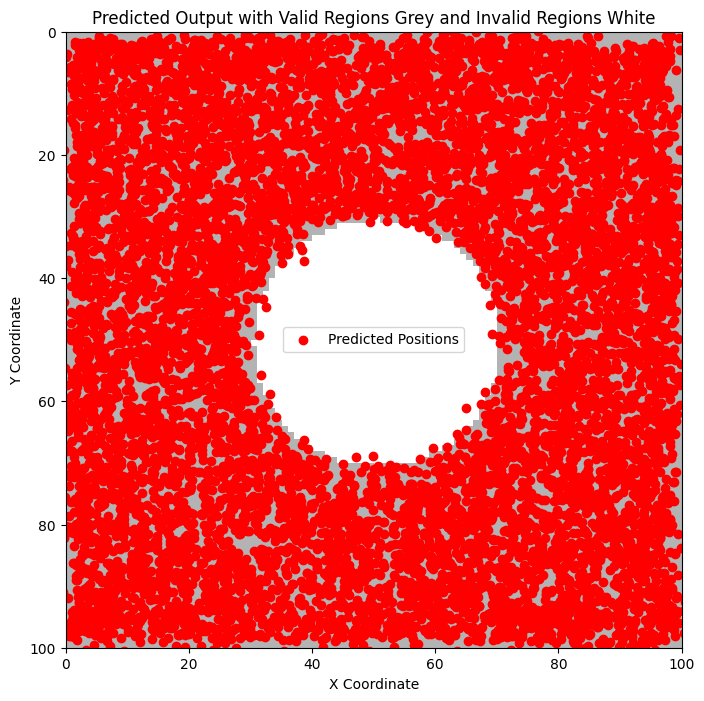

In [16]:
# Instantiate the model
model = SimplePositioningNetwork()

# Define a loss function (MSE for basic regression)
loss_fn = nn.MSELoss()

# Define an optimizer
optimizer = optim.Adam(model.parameters())

device = "cuda" if torch.cuda.is_available() else "cpu"
train_basic_model(model, train_loader, loss_fn, optimizer, device=device)
test_basic_model(model, test_loader, device=device)
# After training the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
plot_predictions(model, test_loader, region_map, device=device)